# RFM-анализ клиентов аптечной сети

## Описание проекта  

В нашем распоряжении файл с данными о картах лояльности клиентов аптечной сети и привезанные к ним продажи, доступный по [ссылке](https://drive.google.com/file/d/1zoAy3Y_wh234EL3hmokqXyTVUMQQ2uzG/view?usp=sharing).

Описание данных:

- `datetime` - дата и время чека,
- `shop` - идентификатор аптеки,
- `card` - идентификатор карты лояльности клиента,
- `bonus_earned` - количество заработанных бонусов,
- `dbonus_spent` - количество потраченных бонусов,
- `summ` - сумма покупки,
- `doc_id` - идентификатор чека.

RFM-анализ - это метод анализа данных, который позволяет сегментировать клиентов по давности, частоте и сумме покупок.

Аббревиатура RFM расшифровывается как:

- `Recency` — давность (как давно была последняя покупка каждого клиента),
- `Frequency` — частота (насколько часто клиенты совершали покупки),
- `Monetary` — деньги (общая сумма покупок).

По этим признакам можно разделить всех клиентов на группы и понять, кто из клиентов покупает часто и много, кто — часто, но мало, а кто давно ничего не покупал.  

По каждому из этих параметров клиенты будут разделяться на 3 группы и им будет начисляться определенное количество баллов от 1 до 3. Чем хуже показатель, тем меньшее количество баллов начисляется.

Например, если клиент покупал давно, редко и на маленькую сумму, то ему по всем трем параметрам начисляется минимальное количество баллов - по 1. Таким образом, данный клиент будет отнесен к группе "111". В противном случае, если клиент покупает часто, на большую сумму и последняя покупка была недавно - ему начислится по 3 балла за каждый параметр и он будет отнесен к группе "333".

С каждой группой можно строить отдельные коммуникации: давать им разную рекламу и делать разные email-рассылки.


**Цель проекта:**  
Провести RFM-анализ покупателей, дать рекомендации по эффективному взаимодействию с разными группами покупателей, чтобы увеличить их лояльность и сумму покупок.


**План проведения исследования:**  
- Базовый анализ и подготовка данных
- Исследовательский анализ данных
- Рекомендации по результатам исследования


## Базовый анализ и подготовка данных

In [ ]:
# Импортируем нужные библиотеки

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [ ]:
# Форматируем отображения вещественных чисел - оставим 2 знака после точки.

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
# Загрузим файл

!gdown 1zoAy3Y_wh234EL3hmokqXyTVUMQQ2uzG


Downloading...
From: https://drive.google.com/uc?id=1zoAy3Y_wh234EL3hmokqXyTVUMQQ2uzG
To: /content/client_cards.csv
100% 1.92M/1.92M [00:00<00:00, 132MB/s]


In [ ]:
# Прочитаем файл.

try:
    df = pd.read_csv('/content/client_cards.csv')

except FileNotFoundError:
    print("Файл не найден")
except pd.errors.EmptyDataError:
    print("Файл пустой или не содержит данных")
except pd.errors.ParserError:
    print("Ошибка при чтении файла")

In [ ]:
# Посмотрим общую информацию о файле.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21075 entries, 0 to 21074
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   datetime      21075 non-null  object
 1   shop          21075 non-null  object
 2   card          21075 non-null  int64 
 3   bonus_earned  21075 non-null  int64 
 4   bonus_spent   21075 non-null  int64 
 5   summ          21075 non-null  int64 
 6   doc_id        21075 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.1+ MB


In [ ]:
# Посмотрим распределение количественных переменных.

df.describe()

,card,bonus_earned,bonus_spent,summ
count,21075.00,21075.00,21075.00,21075.00
mean,2000200198814.45,31.16,19.66,910.88
std,25492.16,35.80,48.67,1014.21
min,2000200150015.00,0.00,0.00,6.00
25%,2000200178804.00,7.00,0.00,313.00
50%,2000200197126.00,18.00,0.00,630.00
75%,2000200219729.00,46.00,12.00,1127.00
max,2000200259435.00,696.00,1192.00,23229.00


In [ ]:
# Взглянем на первые строки файла.

df.head()

,datetime,shop,card,bonus_earned,bonus_spent,summ,doc_id
0,2021-07-13 12:56:09.000,Аптека 2,2000200195023,51,0,3400,15#2002741#65938#2_29
1,2021-07-30 10:42:00.000,Аптека 2,2000200193494,57,0,747,15#2002972#65955#2_5
2,2021-10-11 12:55:23.000,Аптека 2,2000200199106,92,253,3077,15#2004060#66028#2_29
3,2021-10-14 14:48:56.000,Аптека 2,2000200168768,1,0,54,15#2004107#66031#2_57
4,2021-10-20 11:09:39.000,Аптека 2,2000200226314,101,0,1733,15#2004192#66037#2_16


In [ ]:
print('Количество строк-дубликатов:', df.duplicated().sum())

Количество строк-дубликатов: 0


В нашем файле 21075 строк и 7 колонок.  
Пропусков нет.  
Подозрительных отрицательных значений количественных переменных нет.  
Наименования колонок оформлены корректно.  
Требуется заменить типы данных колонок `datetime` и `card`.

In [ ]:
# Изучим внимательнее колонку с суммами покупок.
df['summ'].describe()

count   21075.00
mean      910.88
std      1014.21
min         6.00
25%       313.00
50%       630.00
75%      1127.00
max     23229.00
Name: summ, dtype: float64

Как мы видим, средняя величина покупки (910,88 руб) значительно больше медианной (630 руб.). Это говорит на о наличии значительного количества выбросов (т.е., покупок на аномально высокие суммы).

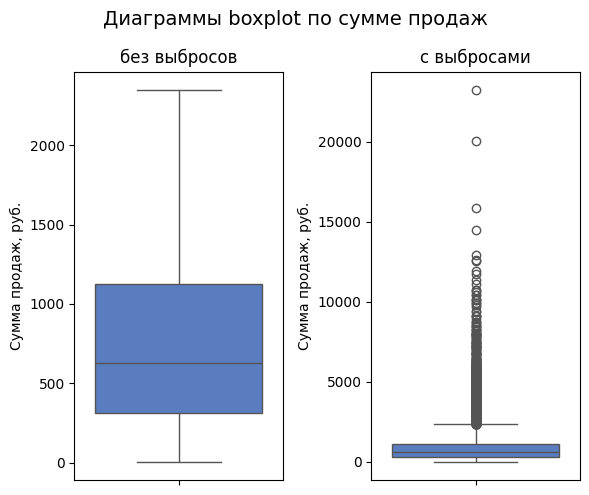

In [ ]:
# Визуализируем эти данные на диаграммах boxplot с выбросами и без выбросов.

plt.figure(figsize=(6, 5))

plt.subplot(1, 2, 2)
sns.boxplot(y=df['summ'], palette='muted')
plt.title('с выбросами')
plt.ylabel('Сумма продаж, руб.')

plt.subplot(1, 2, 1)
sns.boxplot(y=df['summ'], showfliers=False, palette='muted')
plt.title('без выбросов')
plt.ylabel('Сумма продаж, руб.')

plt.suptitle('Диаграммы boxplot по сумме продаж', fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
# Рассчитаем величину суммы покупки, значения выше которой можно считать выбросами.

Q1 = df['summ'].quantile(0.25)
Q3 = df['summ'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR

print('Верхняя граница для выбросов:', upper_bound, 'руб.')

Верхняя граница для выбросов: 2348.0 руб.


In [ ]:
print('Количество покупок на аномально высокую сумму:', df[df['summ'] > 2348].shape[0])

Количество покупок на аномально высокую сумму: 1385


In [ ]:
# Приведем даты к типу "datetime" и рассмотрим их диапазон.

df['datetime'] = pd.to_datetime(df['datetime'])

print('Минимальная дата:', df['datetime'].min())
print('Максимальная дата:', df['datetime'].max())

Минимальная дата: 2021-07-12 09:12:43
Максимальная дата: 2022-06-09 21:49:45


In [ ]:
# Приведем идентификаторы карт лояльности к строковому значению.

df['card'] = df['card'].astype(str)

In [ ]:
print('Количество уникальных номеров карт лояльности:', df['card'].nunique())

Количество уникальных номеров карт лояльности: 5926


**Резюме подраздела:**

- в имеющемся файле 21075 строк и 7 колонок,
- пропущенных значений и полных строк-дубликатов нет,
- названия колонок оформлены корректно,
- диапазон анализа - с 12.07.2021 до 09.06.2022 г.,
- в данных присутствует 5926 уникальных карт лояльности,
- для проведения RFM-анализа потребуются только 3 колонки - `datetime`, `card` и `summ`,
- значения в этих колонках подозрений не вызывают,
- тип данных колонок `datetime` и `card` скорректировали на правильный.



## RFM-анализ

Приведем данные в удобный для расчетов вид. Создадим новый датафрейм, в котором сгруппируем данные по идентификаторам карт лояльности. Для каждой карты рассчитаем:
- сумму покупок,
- количество покупок,
- дату последней покупки,
- количество дней, которое прошло с даты последней покупки до максимальной даты в наших данных (т.е., до 09.06.2022).

In [ ]:
df_grouped = df.groupby('card').agg(
    purchase_sum = ('summ', 'sum'),
    purchase_amount = ('summ', 'count'),
    last_purchase = ('datetime', 'last'),
).reset_index()

In [ ]:
df_grouped['purchase_days'] = (max(df['datetime']) - df_grouped['last_purchase']).dt.days
df_grouped

,card,purchase_sum,purchase_amount,last_purchase,purchase_days
0,2000200150015,21,1,2021-07-19 09:37:20,325
1,2000200150022,1351,1,2021-12-07 20:25:21,184
2,2000200150053,713,2,2022-03-17 20:50:23,84
3,2000200150091,3549,5,2022-06-05 11:49:47,4
4,2000200150107,1735,3,2022-06-02 17:54:19,7
...,...,...,...,...,...
5921,2000200259015,664,1,2022-06-07 17:08:45,2
5922,2000200259381,245,1,2022-06-07 19:19:12,2
5923,2000200259398,395,1,2022-06-07 19:37:59,2
5924,2000200259404,784,1,2022-06-08 09:46:52,1


Для оценки порогов, по которым мы будем группировать клиентов, создадим список от 0.1 до 1 с шагом 0.1 и используем его для визуализации распределений суммы, количества и дней покупок.

In [ ]:
quantiles = [round(el, 2) for el in np.arange(0.1, 1.1, 0.1)]
df_grouped['purchase_sum'].quantile(quantiles)

0.10      408.00
0.20      622.00
0.30      846.50
0.40     1106.00
0.50     1475.50
0.60     2022.00
0.70     2743.00
0.80     4082.00
0.90     6910.50
1.00   163943.00
Name: purchase_sum, dtype: float64

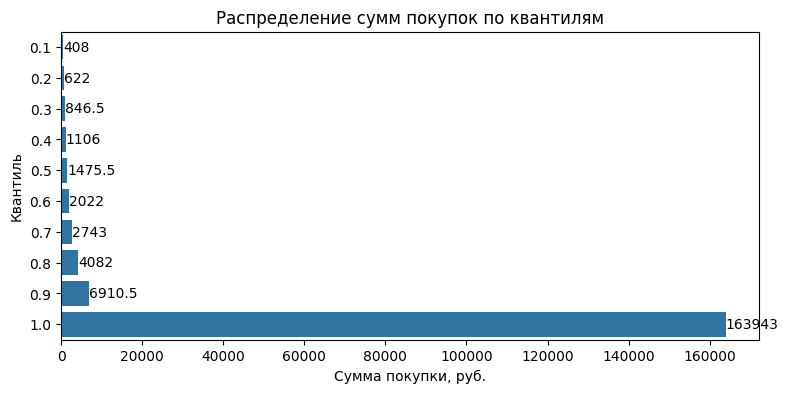

In [ ]:
# Визуализируем распределение сумм покупок.

plt.figure(figsize=(9, 4))

ax = sns.barplot(df_grouped['purchase_sum'].quantile(quantiles), orient='h')

plt.title('Распределение сумм покупок по квантилям')
plt.xlabel('Сумма покупки, руб.')
plt.ylabel('Квантиль')

ax.bar_label(ax.containers[-1]);

Мы можем разделить весь ряд на равные части. Т.е., в качестве порогов для разделения можем взять значения, соответсвующие 0,33 и 0,66 квантилям.
- если значения меньше 0,33 квантиля, то считаем сумму покупок маленькой и начисляем 1 балл,
- если значения от 0,33 до 0,66 квантиля - начисляем 2 балла,
- если значения больше 0,66 квантиля - начисляем 3 балла.

In [ ]:
# Создаем функцию для определения значения в колонке "r" на основе условий

def assign_m(row):
    if row['purchase_sum'] <= df_grouped['purchase_sum'].quantile(0.33):
        return 1
    elif row['purchase_sum'] <= df_grouped['purchase_sum'].quantile(0.66):
        return 2
    else:
        return 3

df_grouped['m'] = df_grouped.apply(assign_m, axis=1)

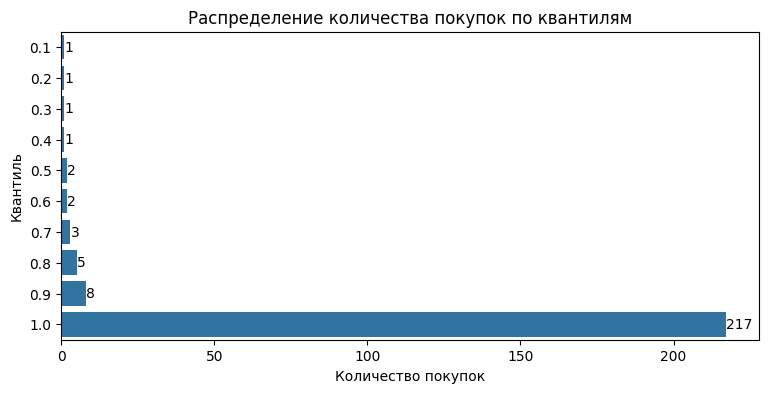

In [ ]:
# Визуализируем распределение количества покупок.

plt.figure(figsize=(9, 4))

ax = sns.barplot(df_grouped['purchase_amount'].quantile(quantiles), orient='h')

plt.title('Распределение количества покупок по квантилям')
plt.xlabel('Количество покупок')
plt.ylabel('Квантиль')

ax.bar_label(ax.containers[-1]);

На графике мы видим довольно четкие границы для сегментации. Этот ряд мы можем разделить по следующему принципу:
- если совершена одна покупка, то относим этого клиента к редко покупающим и начисляем 1 балл,
- если совершены две покупки, то начисляем 2 балла,
- если совершено более 2 покупок, то считаем клиента часто покупающим и начисляем 3 балла.

In [ ]:
def assign_f(row):
    if row['purchase_amount'] == 1:
        return 1
    elif row['purchase_amount'] == 2:
        return 2
    else:
        return 3

df_grouped['f'] = df_grouped.apply(assign_f, axis=1)

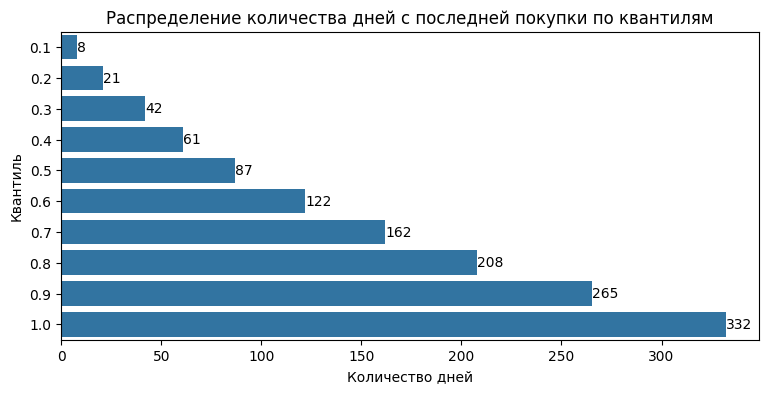

In [ ]:
# Визуализируем распределение количества дней с последней покупки.

plt.figure(figsize=(9, 4))

ax = sns.barplot(df_grouped['purchase_days'].quantile(quantiles), orient='h')

plt.title('Распределение количества дней с последней покупки по квантилям')
plt.xlabel('Количество дней')
plt.ylabel('Квантиль')

ax.bar_label(ax.containers[-1]);

Мы можем разделить эти распределения на 3 равные части по 0,33 и 0,66 квантилям, то в отличие от суммы покупок здесь обратная логика - чем меньше количество дней с даты последней покупки, тем лучше (тем больше баллов начисляем).

In [ ]:
def assign_r(row):
    if row['purchase_days'] <= df_grouped['purchase_days'].quantile(0.33):
        return 3
    elif row['purchase_days'] <= df_grouped['purchase_days'].quantile(0.66):
        return 2
    else:
        return 1

df_grouped['r'] = df_grouped.apply(assign_r, axis=1)

In [ ]:
# Создадим отдельную колонку, в которой укажем трехзначное обозначение группы.

df_grouped['rfm'] = df_grouped.apply(lambda row: f"{row['r']}{row['f']}{row['m']}", axis=1)

In [ ]:
# Создадим отдельную колонку, в которой суммируем полученное количество баллов для каждого клиента.

df_grouped['rfm_score'] = df_grouped[['r', 'f', 'm']].sum(axis=1)

Сначала проведем поверхностный анализ.

В зависимости от суммы набранных баллов условно разделим всех клиентов на 4 сегмента:
- если набрано минимальное количество баллов (3) - `Lost`,
- если набрано 4-5 баллов - `At risk`,
- если набрано 6-7 баллов - `Potential`,
- если набрано 8-9 баллов - `Loyal`.
---

Клиенты `Lost` - это клиенты, покупавшие давно, редко и на маленькую сумму. Можем условно считать их потерянными. Можно не прилагать особых усилий на их возврат.

Клиенты `At risk` - клиенты могут быть потеряны. Нужно вызвать у них интерес и удержать.

Клиенты `Potetntial` - перспективные клиенты, которых можно подтянуть в группу лучших клиентов.

Клиенты `Loyal` - наиболее лояльные и ценные для нас клиенты. Им нужно уделить все внимание и заботу.

---

Посчитаем, по сколько клиентов в каждом из этих сегментов.

In [ ]:
df_grouped['customer_segment'] = pd.cut(
    df_grouped['rfm_score'],
    bins=[0, 3, 5, 7, 9],
    labels=['Lost', 'At risk', 'Potential', 'Loyal']
)

In [ ]:
segment_count = df_grouped.groupby('customer_segment').size().reset_index(name='cnt')

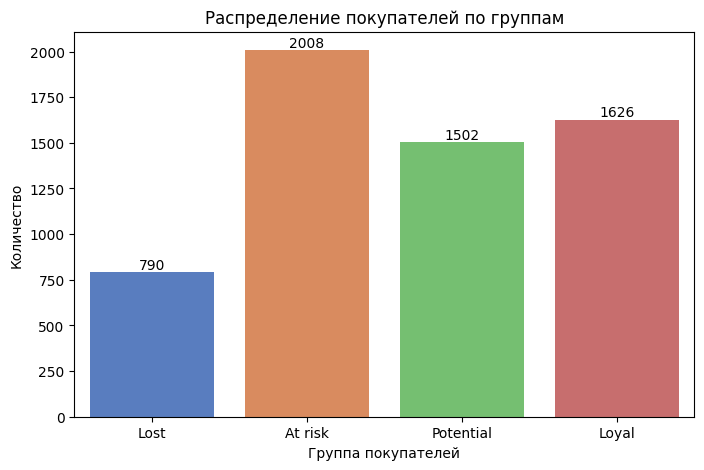

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(x='customer_segment', y='cnt', data=segment_count, palette='muted')
plt.title('Распределение покупателей по группам')
plt.xlabel('Группа покупателей')
plt.ylabel('Количество')
plt.xticks(rotation=0)

for index, value in enumerate(segment_count['cnt']):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()

Самый многочисленный сегмент - `At risk` - 2008 клиентов.

---
Теперь рассчитаем количество клиентов непосредственно в группах RFM в абсолютном и процентном выражении, а также визуализируем на диаграмме treemap.

In [ ]:
df_treemap = df_grouped.groupby('rfm').size().reset_index(name='count').sort_values(by='rfm', ascending=False)
df_treemap['share_%'] = (df_treemap['count'] / df_treemap['count'].sum()) * 100
df_treemap

,rfm,count,share_%
26,333,873,14.73
25,332,208,3.51
24,331,32,0.54
23,323,67,1.13
22,322,164,2.77
21,321,75,1.27
20,313,52,0.88
19,312,178,3.00
18,311,332,5.60
17,233,478,8.07


In [ ]:
px.treemap(df_treemap, path=['rfm'], values='count', title='Группировка клиентов по результатам RFM-анализа')

Поскольку в GitHub не отображаются диаграммы, построенные в plotly, диаграмма дублируется в виде скриншота.

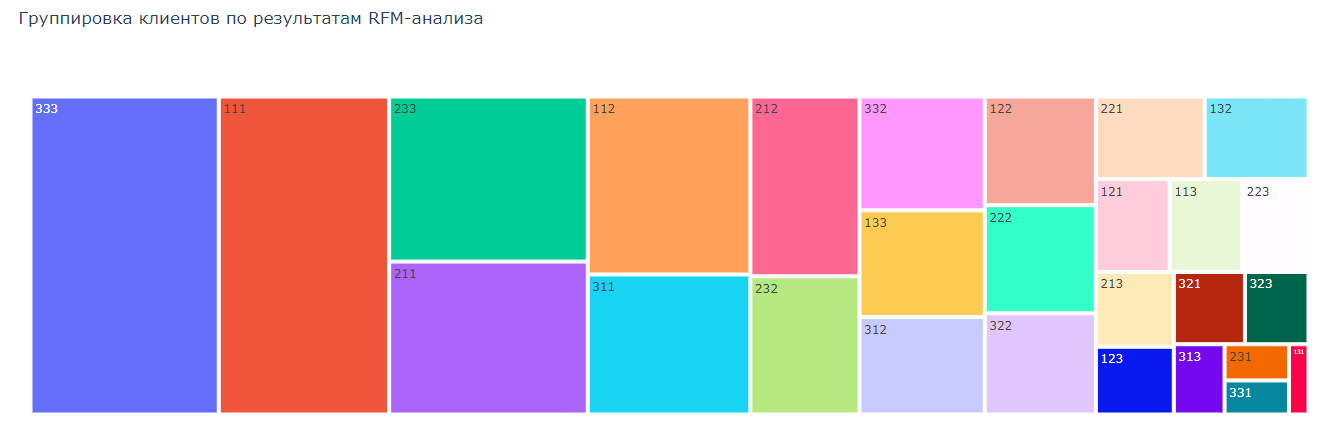

Самыми многочисленными группами у нас получились:
- 333 - самые лояльные клиенты (873 человек или 14,7%),
- 111 - наименее лояльные, "потерянные" клиенты (790 человек или 17,3%),
- 233 - "спящие" лояльные клиенты (478 человек или 8,1%)

**Резюме подраздела:**
- мы рассчитали для каждого уникального клиента:
  - сумму покупок,
  - количество покупок,
  - количество дней, которое прошло с даты последней покупки до максимальной даты в наших данных (т.е., до 09.06.2022),
- визуализировали с помощью столбчатой диаграммы распределения этих трех величин по квантилям,
- приняли решение разделить эти величины на три равные части, взяв за пороги 0,33 и 0,66 квантили,
-  каждому сегменту присвоили определенное количество баллов в зависимости от степени их актуальности исходя из расчета: чем больше сумма и количество покупок и чем меньше количество дней с даты последней покупки, тем больше начисляем баллов,
- в результате сегментации получили 27 групп в зависимости от количества начисленных баллов за показатели давности, частоты и суммы покупок.

## Рекомендации

- **`111`, `112`, `113`** - "не наши клиенты".  
Вряд ли стоит прикладывать много усилий для их возвращения. Возможно, это клиенты другой аптечной сети и когда-то давно совершили разовую покупку просто потому что наша аптека  оказалась рядом. Можно попробовать их вернуть, например, отправив им письмо почему выгодно оставаться с нами с информацией об акциях, скидках и распродажах.
- **`121`, `122`, `123`** - "под угрозой оттока".  
Эти клиенты покупали у нас пару раз более 4 месяцев назад. Можно заинтересовать их скидкой или купоном на покупку, информацией о распродаже. Например, можно прислать персональную подборку товаров и написать - _"Возможно, у вас уже закончились лекарства, которые вы у нас покупали. Они есть у нас в наличии и на них сейчас действует скидка. Ждем вас."_
- **`131`, `132`, `133`** - "уходящие лояльные".  
Необходимо их вернуть. Можно отправить им такие же письма, как и для предыдущей группы и плюс запросить обратную связь - _"Мы хотим стать лучшим выбором для вас. Что вы хотели бы улучшить? Каких товаров или услуг вам не хватает? "_
Предложить начисление бонусных баллов на карту лояльности за развернуты отзыв.
Вероятно, удастся найти и исправить что-то, что не нравится многим клиентам.
- **`2хх`** - "спящие клиенты".  
Они отличаются друг от друга частотой и суммой покупок, но все они делали покупки у нас относительно недавно - от 1,5 до 4,5 месяцев назад - и они еще о нас помнят. Нужно их разбудить и превратить в постоянных клиентов отправляем рассылки с интересными акциями и выгодными предложениями - _"Мы продлили вашу любимую акцию! Успейте сделать заказ!"_, запросить обратную связь - _"Почему перестали приходить к нам?"_
Проактивно начислить дополнительные бонусы на карту лояльности.
- **`311`, `312`** - "новички".  
Нужно произвести благоприятное впечатление - поздравить с первой покупкой и поблагодарить за выбор нашей аптечной сети, пригоасить в наши группы соцсетей, прислать рассылку с описанием преимуществ, ответами на частые вопросы.
- **`313`** - "потенциальные VIP-клиенты".  
Нужно удержать их интерес. В дополнение к мероприятиям для обычных новичков, можно выяснить спомощью небольшого опроса, довольны ли они, были ли просто и удобно оформить заказ и совершить покупку, есть ли еще какие-то пожелания, а также другую информацию, которая пригодится для удержания: что интересно, какие потребности.
Скидки лучше не предлагать и мотивировать чем-то другим. Например, шанс получить подарок в обмен на отзыв.
- **`321`, `322`, `331`, `332`** - "постоянные с небольшим и средним чеком".  
Нужно прпробовать мотивировать их на дополнительные покупки. Будет уместно сделать рассылку с сопутствующими товарами на основе их покупок.
- **`323`** - "постоянные с высоким чеком".  
Можно время от времени отправлять обычные информационные рассылки об акциях, чтобы лишний раз не надоедать этим клиентам.  
- **`333`** - "лучшие клиенты".
Самые ценные и лояльные клиенты, к которым нужен эксклюзивный подход.
Можно предоставить им эксклюзивные предложения. Например, персонифицированная "платиновая" карта лояльности с особым дизайном или услуга бесплатной доставки при покупке на определенную сумму.


